<a href="https://colab.research.google.com/github/dxvsh/LearningPytorch/blob/main/PytorchZTM/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [23]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.1+cu121'

## 1. Data (preparing and loading)

We'll create some data on our own for trying things out.

Our inputs will be points lying b/w : 0 and 1 with a step size of 0.02.
And our output y will be : 0.7x + 0.3, so a straight line.

In [25]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create synthetic data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step)
X = X.reshape(-1, 1)
y = weight * X + bias

# so essentially these datapoints follow the equation of the line : y = 0.7x + 0.3

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Split data into training and test sets

> Note: When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn from training data and then evaluate it on test data to get an indication of how well it generalizes to unseen examples.

In [26]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

(len(X_train), len(y_train)), (len(X_test), len(y_test))

((40, 40), (10, 10))

So, we have now 40 samples for training (`X_train` and `y_train`) and 10 samples for testing (`X_test` and `y_test`)

The model we create is going to try and learn the relationship between `X_train` & `y_train` and then we will evaluate what it learns on `X_test` and `y_test`.

### Plotting and vizualizing our data:

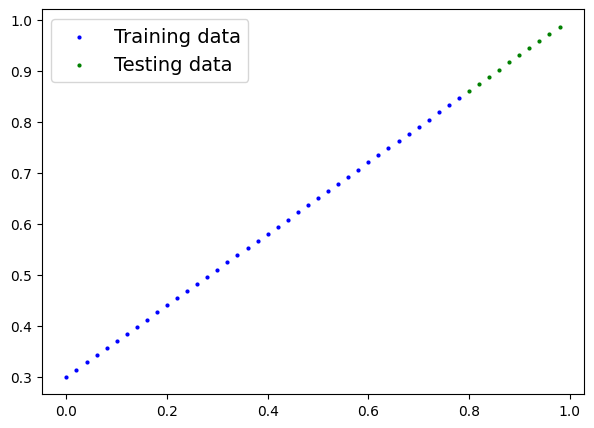

In [27]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(7, 5))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions()

## Build model

We'll try to build a standard Linear Regression model to predict the values for the green dots (testing data) by learning from the train data

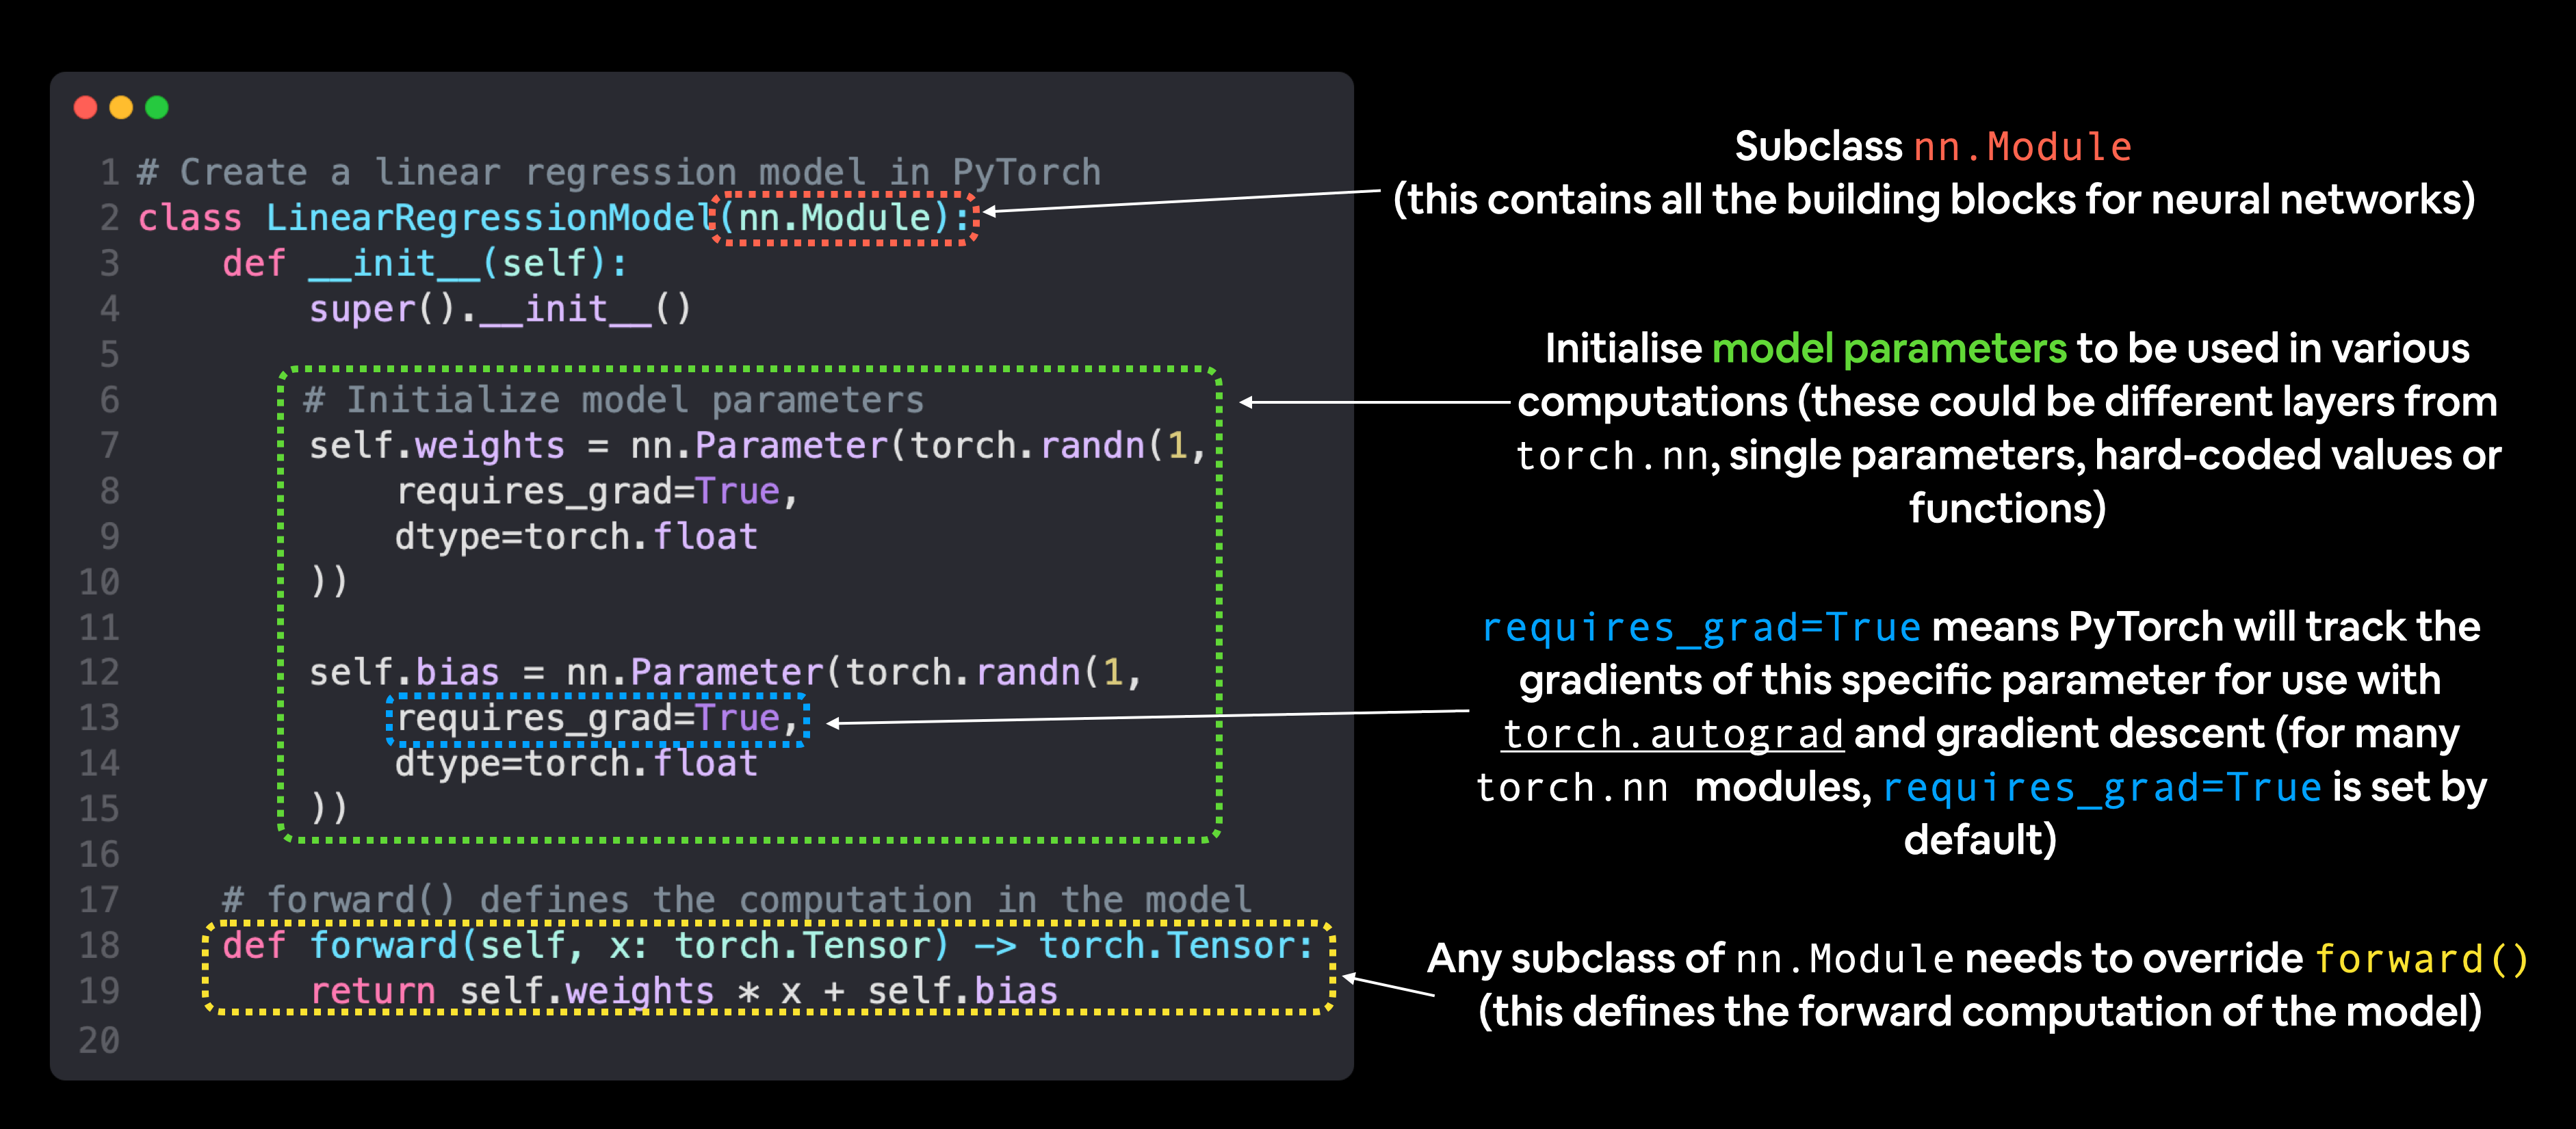

In [46]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

## Checking the contents of a PyTorch model

In [47]:
torch.manual_seed(42) # set manual seed since nn.Parameter are randomly initialized

model_0 = LinearRegressionModel() # create an instance of the model

list(model_0.parameters()) # check the parameters

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using `.state_dict()` method


In [48]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

These are the randomly initialised weights and biases for our model and so obviously they're quite bad, very far from the truth.

## Making predictions using `torch.inference_mode()`

To check this we can pass it the test data X_test to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.

In [49]:
# make predictions with the model
with torch.inference_mode():
    y_preds = model_0(X_test)

`torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the `forward()` method) faster.

In [50]:
# check the predictions

print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


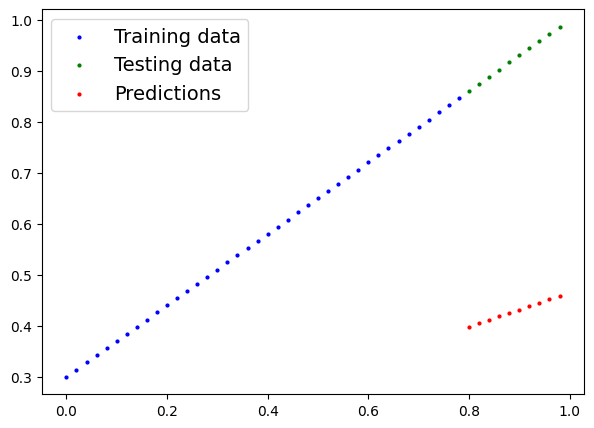

In [51]:
# check the predictions
plot_predictions(predictions=y_preds)

Since our weights and biases were randomly initialised and there wasn't any training, our model predictions are quite awful right now

## 3. Train model

For our model to update its parameters on its own, we'll need to add a few more things to our recipe i.e. a **loss function** as well as an **optimizer**.

- **Loss function**:  Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. Pytorch has plenty of built in loss functions in `torch.nn`
    - For example: MAE, MSE for regresession problems, Binary cross entropy for binary classification problem

- **Optimizer** : Tells your model how to update its internal parameters to best lower the loss. There are various optimization functions in `torch.optim`.
    - For example: SGD (`torch.optim.SGD()`) and Adam optimizer (`torch.optim.Adam()`)


For this example, we'll use the MAE loss (`torch.nn.L1Loss`), MAE measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.

And we'll use SGD (stochastic gradient descent : `torch.optim.SGD(params, lr)`) for our optimizer, where:
    
-  `params` is the **target parameters you'd like to optimize** (e.g. the weights and bias values we randomly set before).

- `lr` is the **learning rate**. Larger learning rates will make large updates and smaller learning rates will make smaller updates. This is a hyperparameter since you need to manually set it. Common starting values for the learning rate are `0.01, 0.001, 0.0001`

In [52]:
loss_fn = nn.L1Loss() # MAE loss

# setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

## Creating an optimization loop in PyTorch

Now that we have got a loss function and an optimizer, its time to create a **training loop** and a **testing loop**

The **training loop** involves the model going through the training data and learning the relationships between the features and labels.

The **testing loop** involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

Each of these is called a "**loop**" because we want our model to look (loop through) at each sample in each dataset.

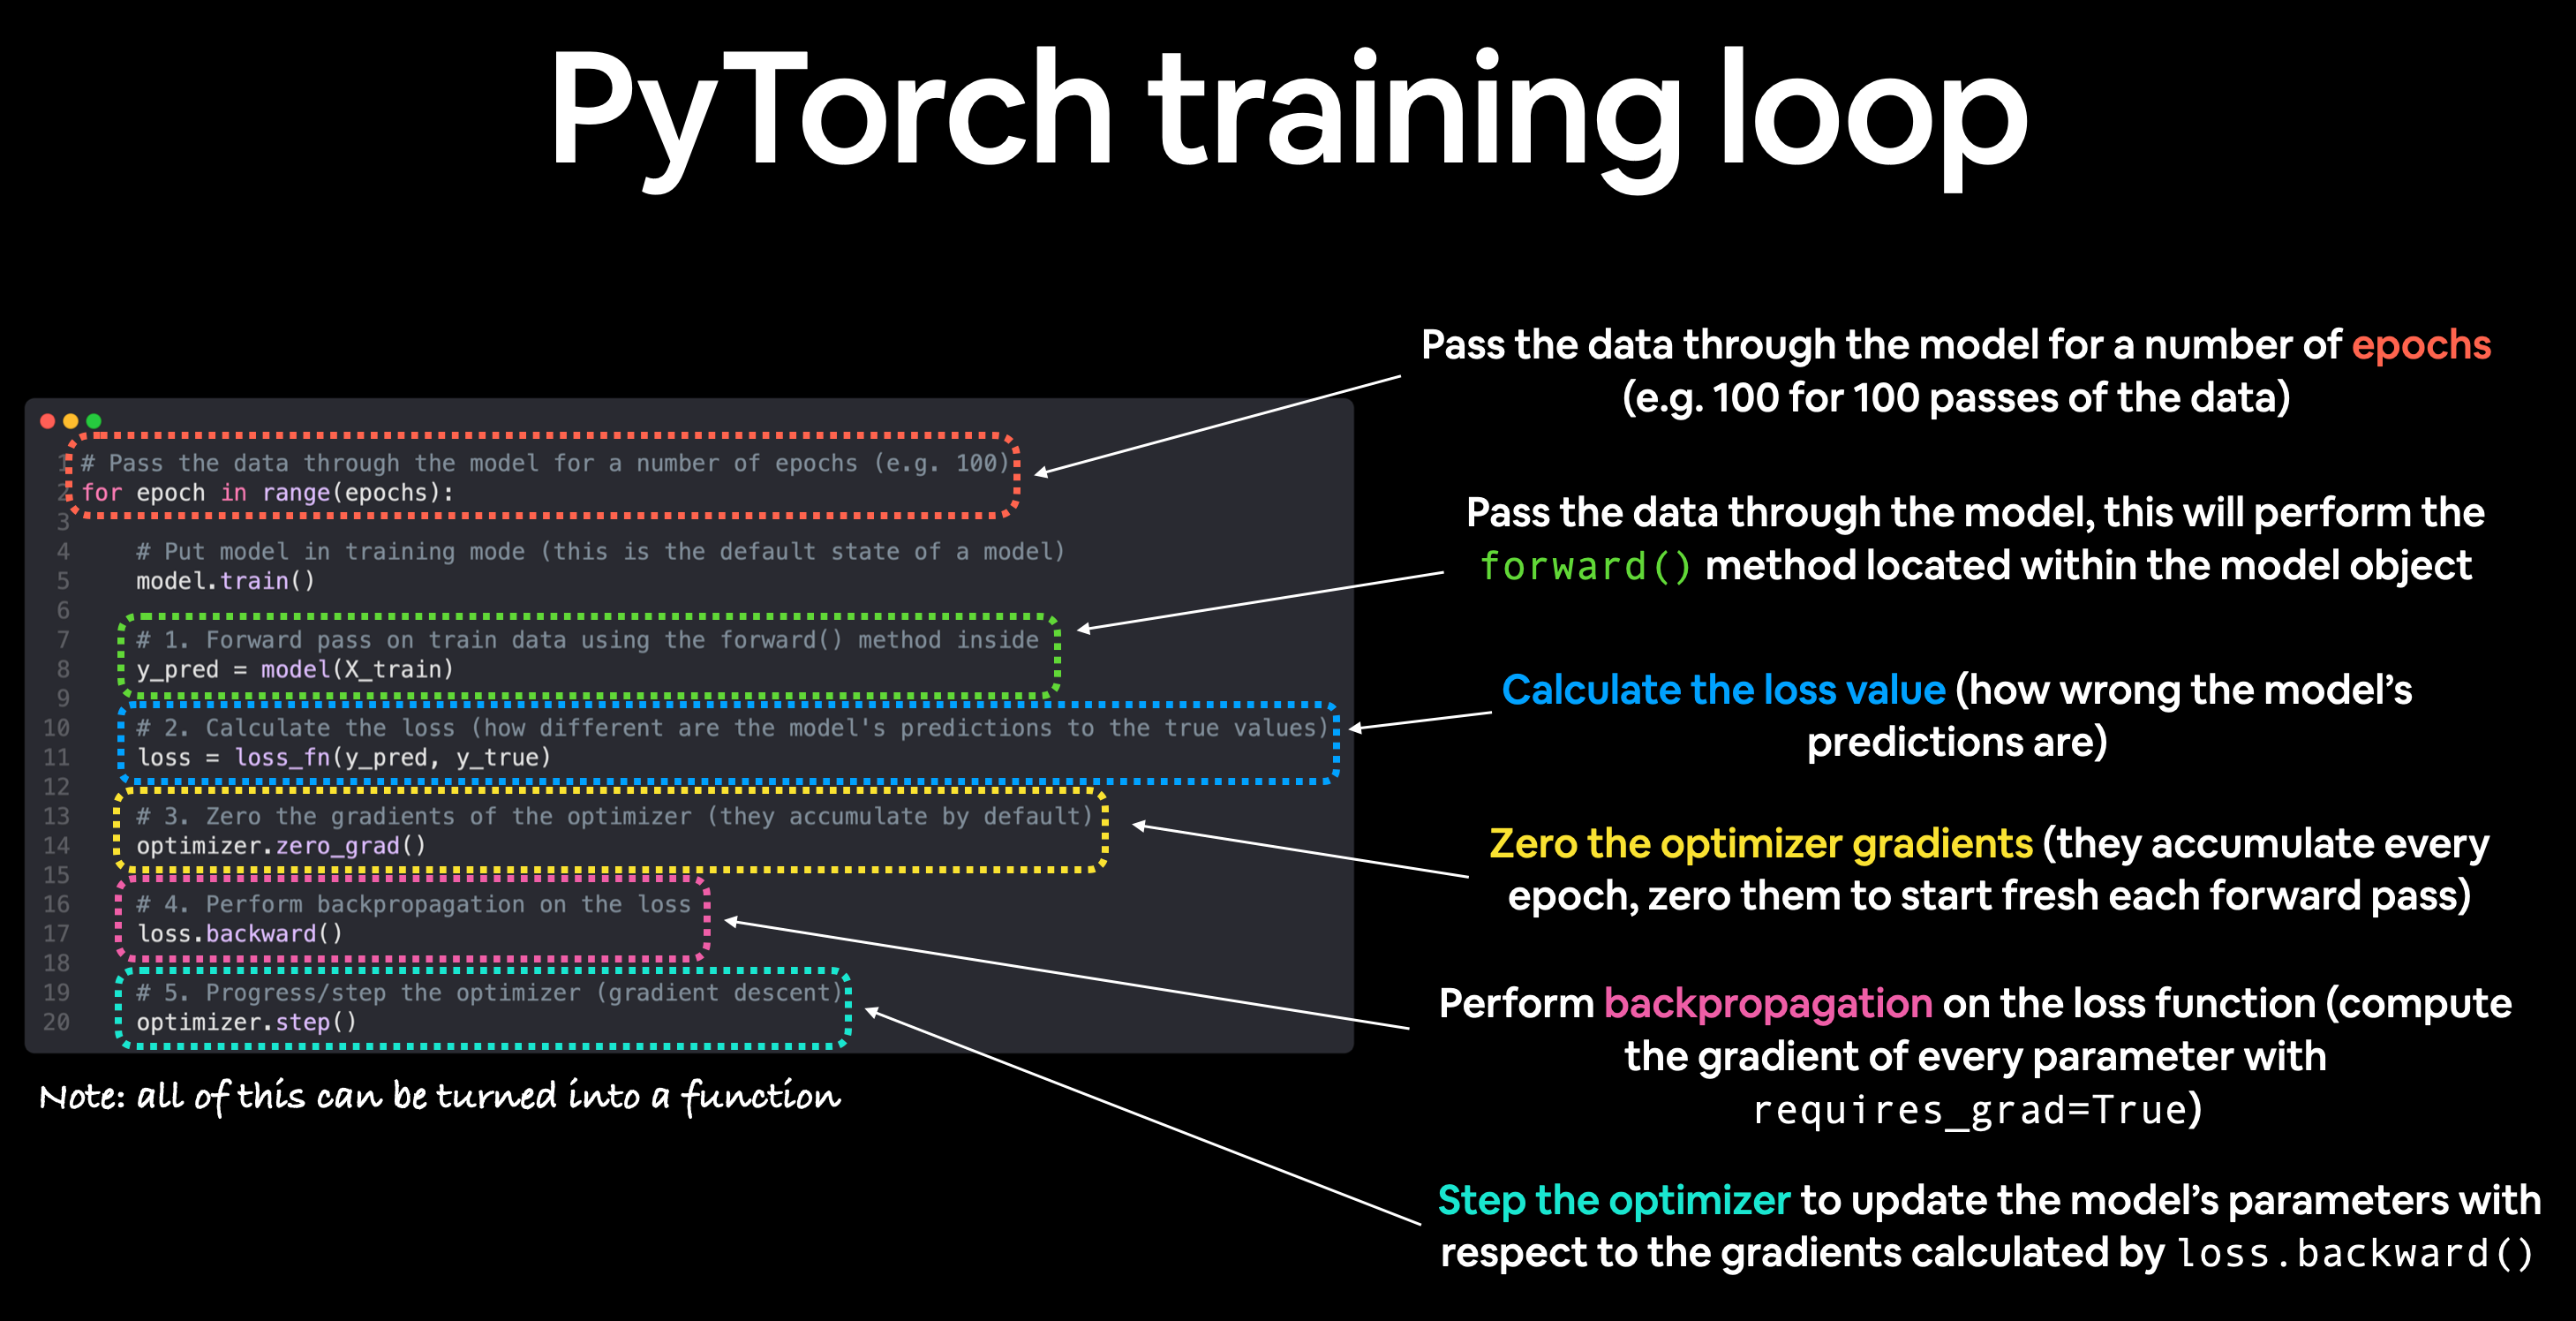



>Note: The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.

>And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:

> - Calculate the loss `(loss = ...)` before performing backpropagation on it `(loss.backward())`.
- Zero gradients `(optimizer.zero_grad())` before computing the gradients of the loss with respect to every model parameter `(loss.backward())`.
- Step the optimizer `(optimizer.step())` after performing backpropagation on the loss `(loss.backward())`.



Notice the testing loop doesn't contain performing backpropagation `(loss.backward())` or stepping the optimizer `(optimizer.step())`, this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

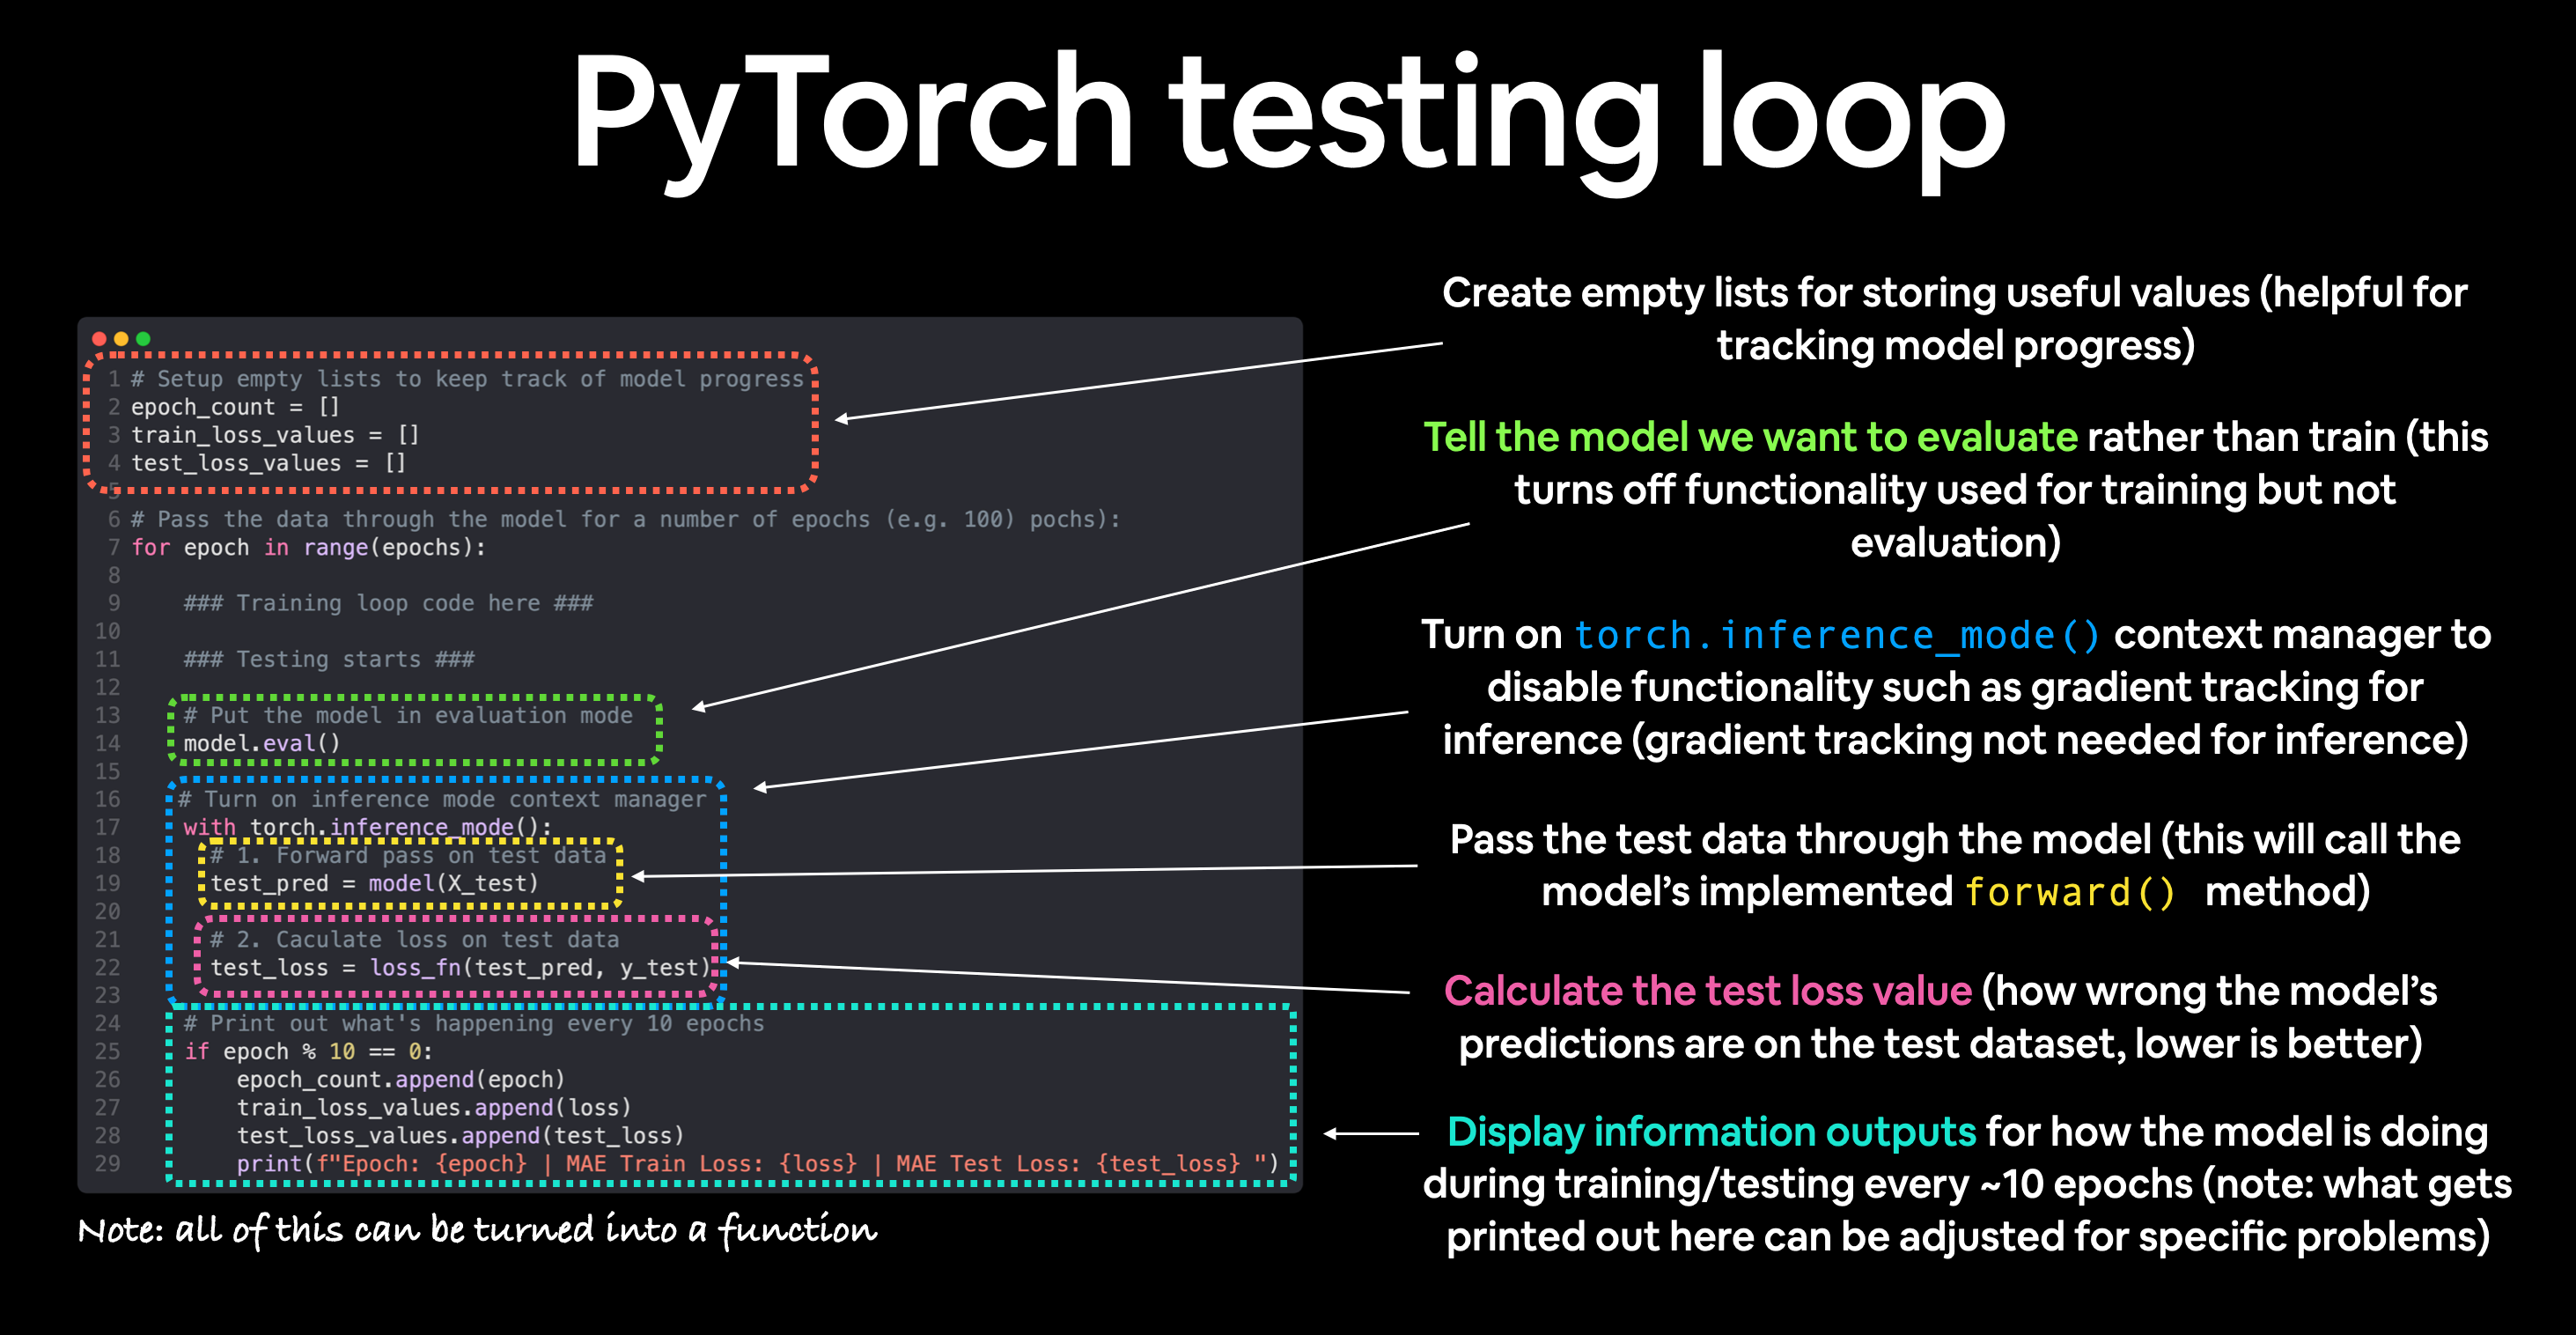

In [53]:
torch.manual_seed(42)

# set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put the model in training mode
    model_0.train()

    # 1. Do the forward pass
    # forward pass on the train data using the forward() method inside
    y_pred = model_0(X_train)

    # 2. Calculate the loss (how different are our model predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad (the gradients accumulate every epoch, zero them to start fresh each forward pass)
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. Update the parameters (weights and biases)
    optimizer.step()

    # After our params have been updated, we can test:
    ### Testing

    # put the model in eval mode
    model_0.eval()

    with torch.inference_mode():
        # 1. do the forward pass on the test data
        test_pred = model_0(X_test)

        # 2. calculate the loss on the test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        # Print out what's happening every 10 epochs
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


Looks like the loss is going down consistently as we progress with more and more epochs. Let's make a plot

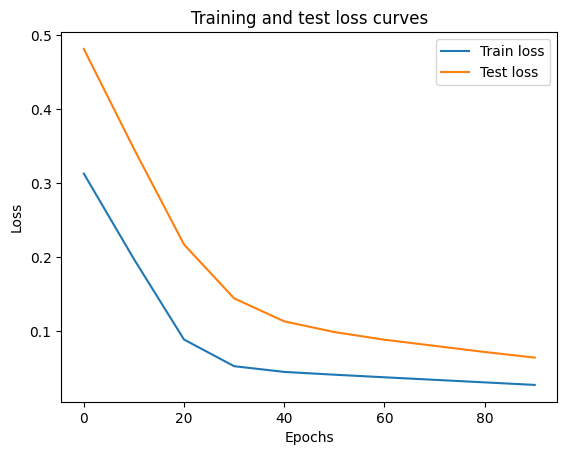

In [54]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Let's inspect our model's `.state_dict()` to see how close our model gets to the original values we set for weights and bias.

In [55]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

The weights and biases have gotten quite a bit better than what they were from the start, they're now much closer to the correct values.
And if we increase the number of epochs, the loss will go further down

## 4. Making predictions with a trained PyTorch model (inference)

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (model.eval()).
2. Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).


In [56]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

Now, we've made predictions with our trained model, let's visualise them to see how far they're from the truth

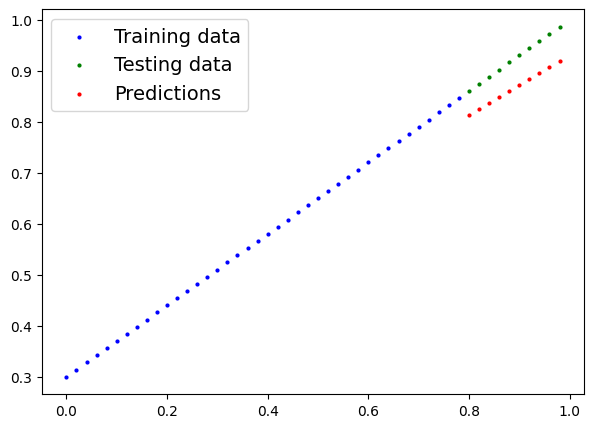

In [57]:
plot_predictions(predictions=y_preds)

This looks much better than before!

## 5. Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the PyTorch saving and loading models guide):

- `torch.save` : Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.

- `torch.load` : Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

- `torch.nn.Module.load_state_dict` : Loads a model's parameter dictionary `(model.state_dict())` using a saved `state_dict()` object.


### Saving a PyTorch model's `state_dict()`

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

- We'll create a directory for saving `models` to called models using Python's `pathlib` module.
- We'll create a file path to save the model to.
- We'll call `torch.save(obj, f)` where obj is the target model's `state_dict()` and `f` is the filename of where to save the model.

>Note: It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`



In [58]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [59]:
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Sep 25 12:44 models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's `state_dict()`


In [60]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-60-c3119fcaa06c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>


Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

**Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?**

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the entire model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of nn.Module).

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

In [61]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.

In [62]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

So, the predictions made by the loaded module are exactly the same as our previous model(made before saving), so looks like our model is being saved and loaded properly

## 6. Putting it all together

Lets put everything we've seen so far together and run through it

In [29]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.1+cu121'

Let's make our code device agnostic, a GPU will be used if available else it will default to CPU

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 6.1 Data

Let's create some data just like before.


In [31]:
# let's set up the same weights and biases as before
weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02)
X = X.reshape(-1, 1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Lets split it into training and test sets now

In [32]:
# split data

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## 6.2 Building a PyTorch linear model

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use `nn.Linear(in_features, out_features)` to do it for us.

Where `in_features` is the number of dimensions your input data has and `out_features` is the number of dimensions you'd like it to be output to. In our case, both of these will be 1 since our data has 1 input feature per label


In [33]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # use nn.Linear() for creating the model parameters
        # linear layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Let's check which device the model currently is on and try changing to GPU if available

In [34]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')



It looks like the model's on the CPU by default. Let's change it to be on the GPU (if it's available).


In [35]:
# set model to GPU if its available otherwise it'll default to CPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## 6.3 Training

Again, before running the training and testing loops, we'll need to define a **loss function** and an **optimizer** to be used.

In [36]:
# create loss function
loss_fn = nn.L1Loss()

# create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

Now since our model is on the GPU, we also need to have the data on the GPU. Otherwise there will be an error.

Training loop:

In [38]:
torch.manual_seed(42)

# set the number of epochs
epochs = 1000

# put data on the available device
# the model and the data need to be on the same device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # call model.train
    model_1.train()

    # do the forward pass
    y_pred = model_1(X_train)

    # calculate the loss
    loss = loss_fn(y_pred, y_train)

    # optimizer.zero_grad!
    optimizer.zero_grad()

    # loss backward!
    loss.backward()

    # optimizer.step
    optimizer.step()

    ### Testing

    # call model.eval
    model_1.eval()

    # forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred, y_test)

    # print whats happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [39]:
# lets check the params after training
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

Now the weights and biases are much closer to the orginal! the model has learnt well


## Making predictions

In [40]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

Now let's plot our model's predictions.

> Note: Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. So you might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. To fix this, you can call `.cpu`() on your target tensor to return a copy of your target tensor on the CPU.


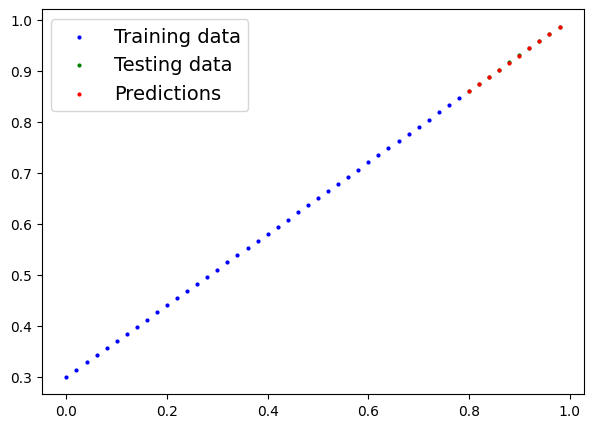

In [41]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

The new model is much better, the extra training epochs really helped to get the weights and biases closer to their correct values

## 6.5 Saving and loading a model

In [42]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


### Try loading it back in and verify everything works

In [47]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}") # make sure model is on correct device (should be same as data)

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


<ipython-input-47-bb5610768030>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


Now we can test whether this loaded module gives the same predictions as the model made prior to saving

In [48]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

Everything seems to work nicely!